In [98]:
from sklearn import *
from tensorflow import keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_digits
from tensorflow.keras.utils import to_categorical
import pandas as pd
import os
from collections import Counter
root_dir = r'/Users/pankaj/Library/Mobile Documents/com~apple~CloudDocs/Capstone/Wikipedia Data'


result_path = annot_file_path = os.path.join(root_dir , 'comments_with_grouped_annoptations.tsv')

merged_comments = pd.read_table(result_path)


In [99]:
print (merged_comments.head())

   Unnamed: 0  rev_id                                            comment  \
0           0   37675  `-NEWLINE_TOKENThis is not ``creative``.  Thos...   
1           1   44816  `NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...   
2           2   49851  NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...   
3           3   89320   Next, maybe you could work on being less cond...   
4           4   93890               This page will need disambiguation.    

   year  logged_in       ns  sample  split  worker_id  quoting_attack  \
0  2002      False  article  random  train       9721             0.0   
1  2002      False  article  random  train      20234             0.0   
2  2002      False  article  random  train      26474             0.0   
3  2002       True  article  random    dev      26738             0.0   
4  2002       True  article  random  train       8010             0.0   

   recipient_attack  third_party_attack  other_attack  attack  
0               0.0                 0.0 

In [100]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np



In [101]:
merged_comments['recipient_attack'] = merged_comments['recipient_attack'].apply(lambda x : 1 if x> 1 else 0 )
X_train = merged_comments['comment']
y = merged_comments['recipient_attack']
one_hot_train_labels = to_categorical(y)

In [102]:
sequence

<module 'tensorflow.keras.preprocessing.sequence' from '/Users/pankaj/anaconda/envs/nlp/lib/python3.7/site-packages/tensorflow_core/python/keras/api/_v2/keras/preprocessing/sequence/__init__.py'>

In [103]:
one_hot_train_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [104]:
merged_comments['new_attack'] = merged_comments['attack'].apply(lambda x : 1 if x> 1 else 0 )

In [105]:
Counter(merged_comments['attack'])

Counter({0.0: 57233,
         4.0: 4133,
         2.0: 10147,
         1.0: 20876,
         3.0: 6143,
         6.0: 2646,
         7.0: 2439,
         5.0: 3127,
         8.0: 2506,
         9.0: 2598,
         14.0: 132,
         10.0: 1920,
         11.0: 159,
         18.0: 115,
         12.0: 152,
         19.0: 108,
         26.0: 113,
         15.0: 125,
         28.0: 113,
         25.0: 95,
         17.0: 119,
         23.0: 91,
         21.0: 78,
         13.0: 116,
         30.0: 17,
         27.0: 118,
         16.0: 104,
         24.0: 98,
         20.0: 82,
         29.0: 69,
         22.0: 88,
         36.0: 2,
         31.0: 1,
         42.0: 1})

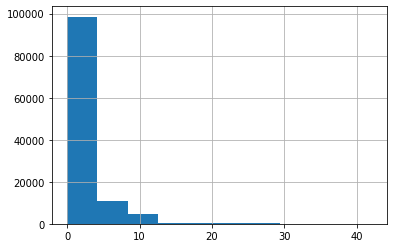

In [106]:
merged_comments.attack.hist()

In [107]:
######



In [108]:
one_hot_train_labels.shape

(115864, 2)

In [109]:
one_hot_train_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [110]:
merged_comments['recipient_attack'].unique()

array([0, 1])

### TODO change model with proper word settings 

In [111]:
# Prepare training input  
training_samples = 90000
validation_samples = 10000
max_words = 30000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 187899 unique tokens.


In [112]:
from collections import Counter
comment_lengths = [len (seq) for seq in sequences]

In [113]:
word_counts_per_review = Counter(comment_lengths)

In [114]:
import numpy as np
np.percentile(comment_lengths, 90)

154.0

<BarContainer object of 1259 artists>

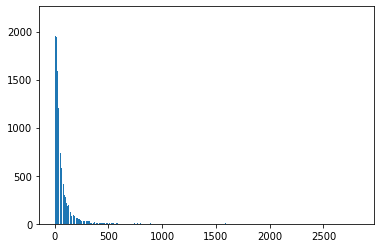

In [115]:
plt.bar( word_counts_per_review.keys(), word_counts_per_review.values())

In [116]:
maxlen = 150

In [117]:
data = pad_sequences(sequences, maxlen=maxlen)
print('Shape of data tensor:', data.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
x_train = data[:training_samples]
x_val = data[training_samples: (training_samples + validation_samples)]
x_test = data[(training_samples + validation_samples) : ]

Shape of data tensor: (115864, 150)


In [118]:
x_test.shape

(15864, 150)

In [119]:
# Prepare labels 
labels = np.asarray(one_hot_train_labels)
print('Shape of label tensor:', labels.shape)
labels = labels[indices]
y_train = labels[:training_samples]
y_val = labels[training_samples: training_samples + validation_samples]
y_test = labels[(training_samples + validation_samples) : ]

Shape of label tensor: (115864, 2)


In [120]:
log_dir='logs/log_basic1'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


tb_collback = keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq= 1)
early_sp_cb= keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.01, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = [tb_collback, early_sp_cb]
#callbacks = []

In [121]:
from tensorboard.plugins import projector

In [122]:
from tensorflow.keras.layers import LSTM
embedding_dim = 16
model = Sequential()
#embedding = Embedding(max_words, embedding_dim , weights =w)
embedding = Embedding(max_words, embedding_dim)

#embedding.trainable = False
model.add(embedding)
model.add(LSTM(32))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          480000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                6272      
_________________________________________________________________
flatten_6 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 66        
Total params: 487,394
Trainable params: 487,394
Non-trainable params: 0
_________________________________________________________________


In [123]:
from tensorflow.keras.layers import LSTM
model = Sequential()
embeddings_index = {}

embedding_dim = 2
with open('../word2_wec_poinc', 'r') as f:
    #emb= f.readlines()


    for line in f:
        values = line.split()
        word = values[0]
        w= word.split(".")[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[w] = coefs

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding = Embedding(max_words, embedding_dim  )
#embedding = Embedding(max_words, embedding_dim)

#embedding.trainable = False
model.add(embedding)
model.add(LSTM(32))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 2)           60000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                4480      
_________________________________________________________________
flatten_7 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 66        
Total params: 65,602
Trainable params: 65,602
Non-trainable params: 0
_________________________________________________________________


In [124]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [125]:
from sklearn.model_selection import train_test_split

X_train, X_test_validate, y_train, y_test_validate = train_test_split(data, labels,
                                                    stratify=labels, 
                                                    test_size=0.40,
                                                    random_state=123)

X_test, X_validate, y_test, y_validate = train_test_split(X_test_validate, y_test_validate,
                                                    stratify = y_test_validate, 
                                                    test_size=0.50,
                                                    random_state=123)

In [126]:
y_train.shape

(69518, 2)

In [127]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(X_train, y_train,
epochs= 4,
batch_size=128,
validation_data=(X_test_validate, y_test_validate), callbacks= callbacks)

Train on 69518 samples, validate on 46346 samples
Epoch 1/4
69518/69518 [==============================] - 68s 974us/sample - loss: 0.4623 - acc: 0.7997 - val_loss: 0.5282 - val_acc: 0.8134
Epoch 2/4
69518/69518 [==============================] - 62s 888us/sample - loss: 0.3460 - acc: 0.8553 - val_loss: 0.3450 - val_acc: 0.8565
Epoch 3/4
69518/69518 [==============================] - 81s 1ms/sample - loss: 0.3180 - acc: 0.8691 - val_loss: 0.3276 - val_acc: 0.8648
Epoch 4/4
69518/69518 [==============================] - 82s 1ms/sample - loss: 0.3037 - acc: 0.8746 - val_loss: 0.3244 - val_acc: 0.8679


In [128]:

with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for subwords in tokenizer.index_word.values():
        f.write("{}\n".format(subwords))
  # Fill in the rest of the labels with "unknown"
    for unknown in range(1, tokenizer.num_words - len(tokenizer.index_word.values())):
        f.write("unknown #{}\n".format(unknown))

In [129]:
model.save('hyperbolic_model.h5')

In [130]:
weights = tf.Variable(model.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [131]:
weights

<tf.Variable 'Variable:0' shape=(29999, 2) dtype=float32, numpy=
array([[ 0.09851319, -0.06032262],
       [-0.01189954,  0.02058272],
       [ 0.08256602, -0.05115252],
       ...,
       [ 0.01382438, -0.01395224],
       [ 0.02214155, -0.02214225],
       [ 0.03708456, -0.03713951]], dtype=float32)>

#predictions = model.predict(test_data)

In [132]:
import os
PATH = os.getenv('PATH')
%env PATH=/Users/pankaj/anaconda/envs/nlp/bin:$PATH
    
%load_ext tensorboard
%tensorboard --logdir logs/log_basic


env: PATH=/Users/pankaj/anaconda/envs/nlp/bin:/Users/pankaj/anaconda/envs/nlp/bin:/Users/pankaj/anaconda/condabin:/Users/pankaj/anaconda/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/opt/X11/bin
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6091), started 0:00:29 ago. (Use '!kill 6091' to kill it.)

In [133]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir logs/log_basic (started 0:00:29 ago; pid 6091)


In [134]:
notebook.display( height=1000) 


Selecting TensorBoard with logdir logs/log_basic (started 0:00:29 ago; port 6006, pid 6091).


In [135]:
test_output = model.predict([X_test])

In [136]:
y_pred = list(map(lambda x: np.argmax(x), test_output))
y_test_bin = list(map(lambda x: np.argmax(x), y_test))

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

cfm = confusion_matrix(y_test_bin,y_pred)

In [137]:
from sklearn.metrics import classification_report
print(accuracy_score(y_test_bin,y_pred))

report = classification_report(y_test_bin,y_pred)

print(report)



0.8679497691278644
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     17835
           1       0.81      0.55      0.66      5338

    accuracy                           0.87     23173
   macro avg       0.85      0.76      0.79     23173
weighted avg       0.86      0.87      0.86     23173



In [138]:
from sklearn.metrics import plot_confusion_matrix

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 257.44, 'Predicted label')

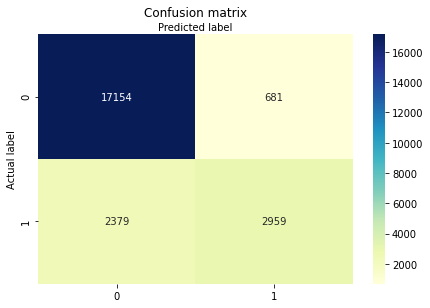

In [140]:
class_names=["Non-Toxic","Toxic"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cfm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [141]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

In [142]:
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/elmo/3"
embed = hub.load(module_url)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [143]:
X_train, X_test_validate, y_train, y_test_validate = train_test_split(merged_comments.comment, merged_comments.recipient_attack,
                                                    stratify=labels, 
                                                    test_size=0.40,
                                                    random_state=123)

In [144]:
DF_train = X_train.to_frame()
DF_train['recipient_attack'] = y_train
DF_train.reset_index(inplace=True)

In [145]:
def preprocess_text(text_eval):
    sequences = tokenizer.texts_to_sequences([text_eval])
    data = pad_sequences(sequences, maxlen=maxlen)
    return data

In [146]:
### Abalation and Get the Vectors of the important trigrams 

NAE_vals_array = np.empty((0,1024), float)
PAE_vals_array = np.empty((0,1024), float)

for index, row in DF_train.iterrows():
    
    text = row.comment.translate(str.maketrans('','',string.punctuation))
    tokens = word_tokenize(text)
    tokens_without_sw = [word for word in tokens if not word in stopwords.words()]
    
    ### First Get the overall Classification
    
    pred_vlaues = model.predict(preprocess_text(str(tokens_without_sw)))
    
    classification = pred_vlaues.argmax()
    
    if classification == 0 and row.recipient_attack == 0:
        mode = 'PAE' # Positive AutoEncoder
    elif classification == 0 and row.recipient_attack == 1:
        mode = 'NAE'
    elif classification == 1 and row.recipient_attack == 0:
        mode = 'PAE'
    elif classification == 1 and row.recipient_attack == 1:
        mode = 'NAE'
        
    ### Get the Elmo vector
    
    text=tf.convert_to_tensor([str(tokens_without_sw)])
    out = embed.signatures['default'](text)['elmo']
  
    pred_vals_array = np.empty((0,2), float)
    
    for i in range(len(tokens_without_sw)-2):
        
        
        
        text_eval = tokens_without_sw[i:i+3]

        a = preprocess_text(str(text_eval))
        pred_vlaues = model.predict(a)
        pred_vals_array = np.vstack((pred_vals_array,pred_vlaues))
        
    if mode == "NAE":

        # Only Negative Vals, and find the index of the highest contributing phrase

        phrase_start_index = pred_vals_array[:,1].argmax()

        ### Get the ELMO Encoding of the entire vector:

        elmo_vecs = np.array(out[0][phrase_start_index:phrase_start_index+3])

        NAE_vals_array = np.vstack((NAE_vals_array, elmo_vecs))
        
        print("NAE")
        print(len(NAE_vals_array))

    elif mode == "PAE":

        # Only Positive Vals, and find the index of the highest contributing phrase

        phrase_start_index = pred_vals_array[:,0].argmax()

        PAE_vals_array = np.vstack((PAE_vals_array,out[0][phrase_start_index:phrase_start_index+3]))
        
        print("PAE")
        print(len(PAE_vals_array))

    if index == 20:
        break

PAE
3
PAE
6
PAE
9
PAE
12
PAE
15
NAE
3
NAE
6
PAE
18
NAE
9
PAE
21


ValueError: attempt to get argmax of an empty sequence

In [147]:
NAE_vals_array = NAE_vals_array.reshape(int(NAE_vals_array.shape[0]/3),3,1024)
PAE_vals_array = PAE_vals_array.reshape(int(PAE_vals_array.shape[0]/3),3,1024)


In [148]:
# lstm autoencoder to recreate a timeseries
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

In [149]:
timesteps = 3
n_features = 1024
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# define model
model_TAE = Sequential()
model_TAE .add(LSTM(1024, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model_TAE .add(LSTM(720, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model_TAE .add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model_TAE .add(LSTM(64, activation='relu', return_sequences=False))
model_TAE .add(RepeatVector(timesteps))
model_TAE .add(LSTM(64, activation='relu', return_sequences=True))
model_TAE .add(LSTM(128, activation='relu', return_sequences=True))
model_TAE .add(LSTM(720, activation='relu', return_sequences=True))
model_TAE .add(LSTM(1027, activation='relu', return_sequences=True))
model_TAE .add(TimeDistributed(Dense(n_features)))
model_TAE .compile(optimizer='adam', loss='mse')
model_TAE.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
lstm_9 (LSTM)                (None, 3, 720)            5025600   
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 128)            434688    
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 64)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 128)           

In [150]:
model_TAE.fit(PAE_vals_array, PAE_vals_array, epochs=3, batch_size=5)

Train on 7 samples
Epoch 1/3
7/7 [==============================] - 6s 877ms/sample - loss: 0.3006
Epoch 2/3
7/7 [==============================] - 0s 68ms/sample - loss: 0.2990
Epoch 3/3
7/7 [==============================] - 0s 67ms/sample - loss: 0.2973
